In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
# Import the machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Import the evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# Import the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
credit_info = pd.read_csv("creditcard.csv")

In [3]:
# Shuffle data
credit_info_shuffled = credit_info.sample(frac=1)
# one-hot encode the target variable
#credit_info_encoded = pd.get_dummies(credit_info_shuffled, columns=["Class"])

# Splitting the data into train and test
training_size = int(0.8 * len(credit_info_shuffled))
Training_set = credit_info_shuffled.iloc[:training_size, :]
Test_set = credit_info_shuffled.iloc[training_size:, :]
# Separate out the input variables and the target variables
X_train = Training_set.iloc[:, :-1]
y_train = Training_set.iloc[:, -1]
X_test = Test_set.iloc[:, :-1]
y_test = Test_set.iloc[:, -1]
# min-max normalize the data using MinMaxScaler
normalizer = MinMaxScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

In [4]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [5]:
y_train.value_counts()/len(y_train)

0    0.998306
1    0.001694
Name: Class, dtype: float64

In [6]:
y_test.value_counts()/len(y_test)

0    0.998139
1    0.001861
Name: Class, dtype: float64

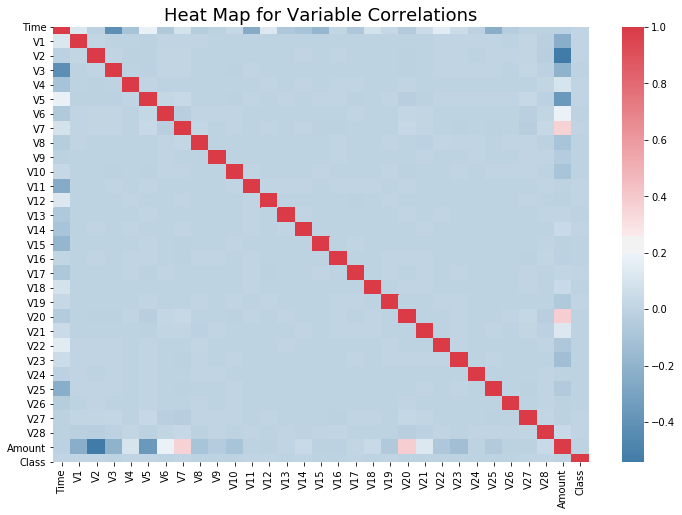

In [7]:
plt.subplots(figsize=(12,8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(X_train_scaled.join(y_train).corr(), cmap = cmap)
plt.title("Heat Map for Variable Correlations", size = 18)
plt.show()

In [8]:
# Let's show again how each variables are correlated to the target variable
# I will take the absolute value of the pearson correlation coefficient 
variable_to_target_correlations = []
for var in X_train_scaled.columns:
    variable_to_target_correlations.append(abs(pearsonr(X_train_scaled.loc[:,var], y_train)[0]))

In [9]:
var_to_target_cor = pd.Series(variable_to_target_correlations, index=X_train_scaled.columns).sort_values(ascending=False)

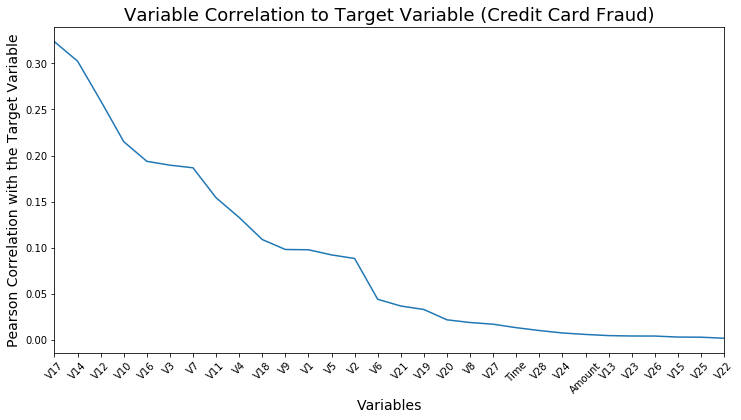

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(var_to_target_cor).sort_values(ascending=False).plot()
ax.set_xticks(range(len(var_to_target_cor)))
ax.set_xticklabels([item for item in var_to_target_cor.index.tolist()], rotation=45)
plt.title("Variable Correlation to Target Variable (Credit Card Fraud)", size=18)
ax.set_ylabel("Pearson Correlation with the Target Variable", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

In [11]:
X_train_scaled.iloc[:,0]

0         0.337452
1         0.259248
2         0.498443
3         0.283208
4         0.851509
            ...   
227840    0.299319
227841    0.288011
227842    0.751615
227843    0.781101
227844    0.892281
Name: Time, Length: 227845, dtype: float64

Some of the variables are weakly correlated with each other, but none are strongly correlated with the target variables

In [12]:
# Let's use random forest to get some ideas about feature importance
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

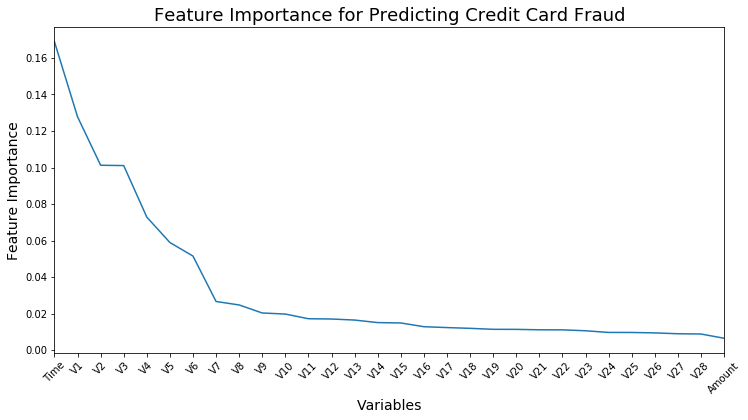

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(feature_importance).sort_values(ascending=False).plot()
ax.set_xticks(range(len(feature_importance)))
ax.set_xticklabels([item for item in feature_importance.index.tolist()], rotation=45)
plt.title("Feature Importance for Predicting Credit Card Fraud", size=18)
ax.set_ylabel("Feature Importance", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

V17, V12, V14, V10, V16, V11 and V18 appear to be more useful in predicting the target values


In [18]:
# Let's evaluate the accuracy, precision, and recall scores of the random forest model
y_pred = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print("Accuracy Score for the rf model is: {}".format(rf_accuracy))
print("Precision Score for the rf model is: {}".format(rf_precision))
print("Recall Score for the rf model is: {}".format(rf_recall))

Accuracy Score for the rf model is: 0.9994557775359011
Precision Score for the rf model is: 0.9213483146067416
Recall Score for the rf model is: 0.7735849056603774


***So for the Random Forest Model, it achieves really accuracy and precision, but suboptimal recall, meaning that there are a substantial number of frauds that are not being detected***

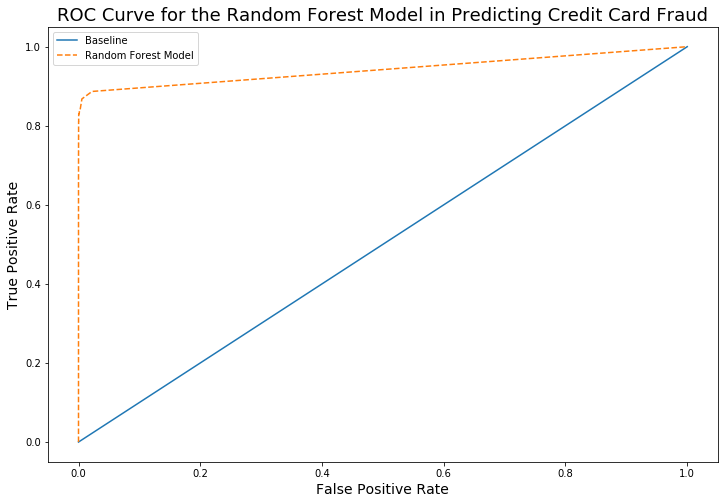

In [19]:
y_score = rf.predict_proba(X_test_scaled)[:, 1]

bl_probs = [0 for a in range(len(y_test))]

bl_fpr, bl_tpr, _ = roc_curve(y_test, bl_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_score)

plt.subplots(figsize = (12, 8))
plt.plot(bl_fpr, bl_tpr, label = "Baseline")
plt.plot(rf_fpr, rf_tpr, linestyle="--", label = "Random Forest Model")
plt.xlabel("False Positive Rate", size=14)
plt.ylabel("True Positive Rate", size=14)
plt.title("ROC Curve for the Random Forest Model in Predicting Credit Card Fraud", size = 18)
plt.legend()
plt.show()



In [20]:
confusion_matrix(y_test, y_pred)

array([[56849,     7],
       [   24,    82]], dtype=int64)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.92      0.77      0.84       106

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### Now let's try other models to see if they can perform even better

In [22]:
important_features = ["V17", "V12", "V14", "V10", "V16", "V11", "V18"]

In [23]:
logreg = LogisticRegression(penalty="l1", solver="liblinear",n_jobs=-1)
logreg.fit(X_train_scaled[important_features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
logreg_y_pred = logreg.predict(X_test[important_features])
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
logreg_precision = precision_score(y_test, logreg_y_pred)
logreg_recall = recall_score(y_test, logreg_y_pred)

print("Accuracy Score for the Lasso Logistic model is: {}".format(rf_accuracy))
print("Precision Score for the Lasso Logistic model is: {}".format(rf_precision))
print("Recall Score for the Lasso Logistic model is: {}".format(rf_recall))

Accuracy Score for the Lasso Logistic model is: 0.11139004950668867
Precision Score for the Lasso Logistic model is: 0.0020505136142274097
Recall Score for the Lasso Logistic model is: 0.9811320754716981


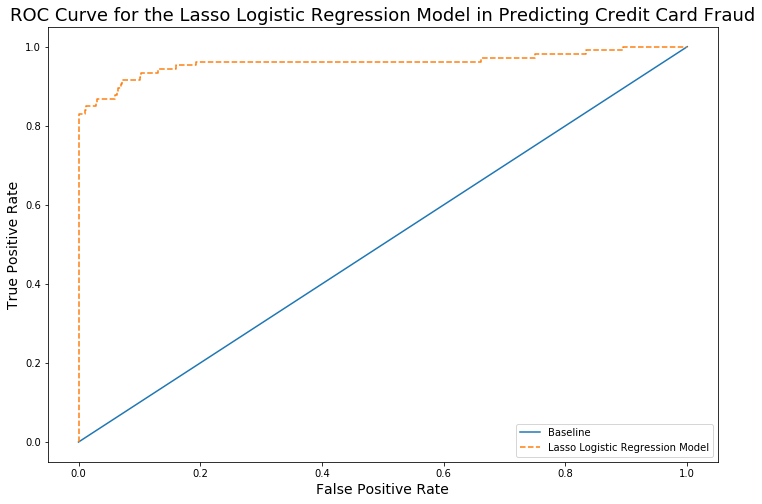

In [28]:
y_score = logreg.predict_proba(X_test_scaled[important_features])[:, 1]

bl_probs = [0 for a in range(len(y_test))]

bl_fpr, bl_tpr, _ = roc_curve(y_test, bl_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, y_score)

plt.subplots(figsize = (12, 8))
plt.plot(bl_fpr, bl_tpr, label = "Baseline")
plt.plot(logreg_fpr, logreg_tpr, linestyle="--", label = "Lasso Logistic Regression Model")
plt.xlabel("False Positive Rate", size=14)
plt.ylabel("True Positive Rate", size=14)
plt.title("ROC Curve for the Lasso Logistic Regression Model in Predicting Credit Card Fraud", size = 18)
plt.legend()
plt.show()


### Yikes! This result sucks! Even though the ROC Curve looks decent